## Financial Big Data Project : Impact of Louvain clustering on GMVP strategy

In [10]:
#we import the diverse librairies and initialise the data path and the different dates and asset names
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from data_cleaning import load_trade,impor_data
from refreshTime import harmoniz_data,refresh_time_without_dask,synchro_data,refresh_time_dask
from back_test import daily_back_testing
import seaborn as sns
import time

import dask
dask.config.set(scheduler="processes")

Date = pd.bdate_range('2010-01-01','2010-12-31')[1:] #We do not take the 1er January where there is no trades
Stock_name = np.array(['AAPL.OQ','AMGN.OQ','AXP.N','BA.N','CAT.N','CSCO.OQ','CVX.N','DOW.N','GS.N','SPY.P','UTX.N','V.N','WMT.N'])

folder_path = 'D:/GitHub/ML_For_Finance/big data/data/data/'

#folder_path ='D:/GitHub/ML for Finance project/ML_For_Finance/big data/Data/data/'
#folder_path = '/Users/franckatteaka/Desktop/cours/Semester III/Financial big data/high freq data/'

## Section 2 : Data Analysis

In [2]:
#the goal is to plot the evolution of the number of trades
n=len(Date)
m=len(Stock_name)
Stock_size = np.zeros((n,m))
#for each date we import the datas and count the numbers of trades for each asset
for i in range(n):
    temp = impor_data(Stock_name,Date[i],folder_path)
    for j in range(m):
        Stock_size[i,j]=len(temp[j])


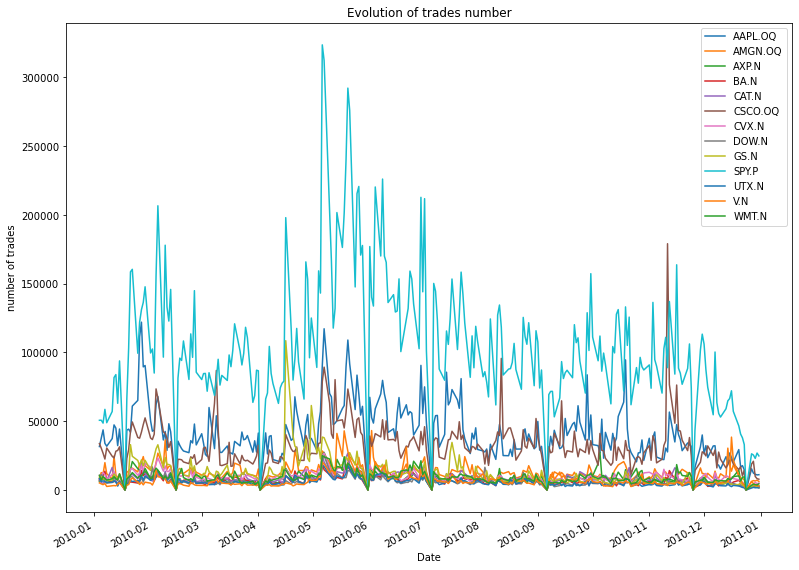

In [3]:
plt.figure(figsize=(13,10))
for j in range(m):
    plt.plot(Date,Stock_size[:,j],label=Stock_name[j])
    
plt.legend()
plt.ylabel("number of trades")
plt.xlabel('Date')
plt.title('Evolution of trades number')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        
plt.gcf().autofmt_xdate()
plt.savefig('figures/number_trades.pdf')

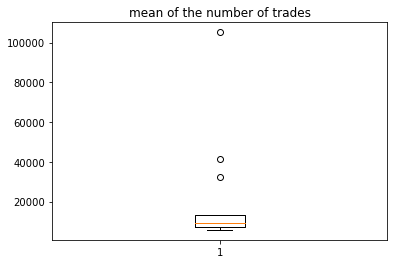

,mean trades
AAPL.OQ,41213.073077
AMGN.OQ,13022.373077
AXP.N,8417.542308
BA.N,6781.303846
CAT.N,8532.884615
CSCO.OQ,32440.665385
CVX.N,9982.492308
DOW.N,6068.430769
GS.N,12532.361538
SPY.P,105240.903846


In [4]:
#we calculate the mean of the trades number per asset to see the repartition of the trades number
mean_number = np.mean(Stock_size,axis=0)
plt.boxplot(mean_number)
plt.title('mean of the number of trades')
plt.savefig('figures/boxplot mean number of trades.pdf')
plt.show()
#in the same way we print the average of the trades number for each assets
DF = pd.DataFrame(data=mean_number[np.newaxis,:].T,index=Stock_name,columns=['mean trades'])
DF

In [5]:
#We verify that we only have 8 business days where we do not have any trades for at least one asset
#we should have 8 no trading days in our data sets 
num_0 =0
for i in range(n):
    if min(Stock_size[i])==0:
        num_0+=1
print('number of day where at least one asset has 0 trades :',num_0)

number of day where at least one asset has 0 trades : 8


D:\Python_file\envs\spyder_RL\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


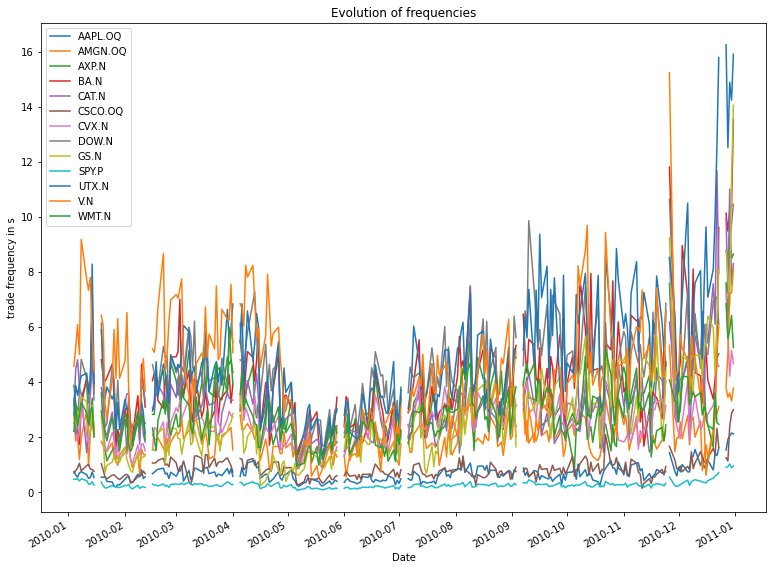

In [6]:
#We will plot the average frequency of all assets for each day
#This will be use to set the dask method to search the refresh time
time_1d = 60*60*6.5

freq = time_1d/Stock_size

plt.figure(figsize=(13,10))
for j in range(m):
    plt.plot(Date,freq[:,j],label=Stock_name[j])
    
plt.legend()
plt.ylabel("trade frequency in s")
plt.xlabel('Date')
plt.title('Evolution of frequencies')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        
plt.gcf().autofmt_xdate()
plt.savefig('figures/trades_frequency.pdf')

In [7]:
#We measure the time to import the data of te day where we have the more data

indice = np.argmax(Stock_size[:,9])
print('date with the more data : ',Date[indice])
start_time = time.time()
impor_data(Stock_name,Date[indice],folder_path)
t = time.time()-start_time
print('maximum time to load all stocks trades with dask : %f seconds'%(t))


date with the more data :  2010-05-06 00:00:00
maximum time to load all stocks trades with dask : 2.160482 seconds


## Section 3 : Data synchronisation

In [5]:
#For each day we import the data and calculate the refresh times and save the lenght of it
n=len(Date)
m=len(Stock_name)
tau = np.zeros((n))

for i in range(n):
    temp1 = impor_data(Stock_name,Date[i],folder_path)
    #We check if we are in a no trading day or not
    if min([len(df) for df in temp1])>0:
        #for the asset data we get the list of refresh time
        temp2 = refresh_time_dask(temp1,Date[i])
        tau[i]=len(temp2)
    else :
        tau[i]=0

No handles with labels found to put in legend.


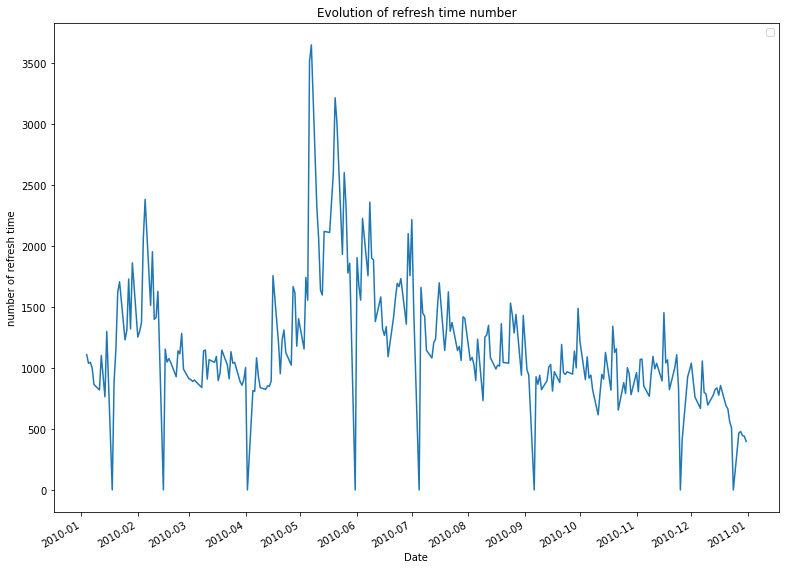

In [8]:
#We plot the evolution of the number of refresh times per day
plt.figure(figsize=(13,10))

plt.plot(Date,tau)
    
plt.legend()
plt.ylabel("number of refresh time")
plt.xlabel('Date')
plt.title('Evolution of refresh time number')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        
plt.gcf().autofmt_xdate()
plt.savefig('figures/number_refresh_time.pdf')

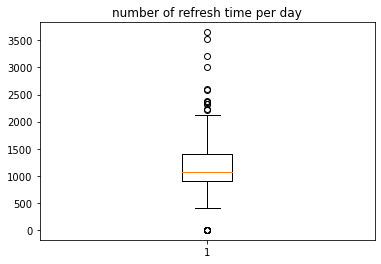

In [16]:
#we create a boxplot to see the repartition of the refresh time
plt.boxplot(tau)
plt.title('number of refresh time per day')
plt.savefig('figures/boxplot number of refresh time per day.pdf')
plt.show()

In [17]:
print('mean of refresh time number :',np.mean(tau))
print('std of refresh time number :',np.std(tau))

mean of refresh time number : 1182.8153846153846
std of refresh time number : 527.7971169743072


In [18]:
#If we take 5 business day we get 'tau_5' refresh times
#The goal is to use 5 business day to calibrate our models
tau_5 = tau[:-4]+tau[1:-3]+tau[2:-2]+tau[3:-1]+tau[4:]

In [20]:
print('mean of refresh time number on 5 business day:',np.mean(tau_5))
print('std of refresh time number on 5 business day:',np.std(tau_5))

mean of refresh time number on 5 business day: 5948.140625
std of refresh time number on 5 business day: 2160.212009395631


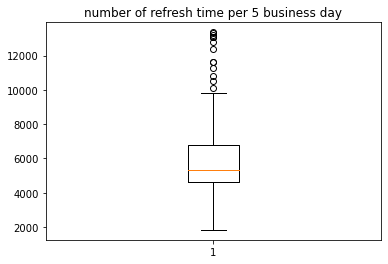

In [21]:
#We see the repartition of 'tau_5'
plt.boxplot(tau_5)
plt.title('number of refresh time per 5 business day')
plt.savefig('figures/boxplot number of refresh time per 5 business day.pdf')
plt.show()

In [3]:
indice=88
print('date with the more data : ',Date[indice])

date with the more data :  2010-05-06 00:00:00


In [3]:
#We measure the time to get the refresh time only for the day with macimum data
temp_t = impor_data(Stock_name,Date[indice],folder_path)
#we start the chronometer
start_time = time.time()
#we get the refresh times
refresh_time_dask(temp_t,Date[indice])
#we save the time
t = time.time()-start_time
print('maximum time to refresh times with dask : %f seconds'%(t))

maximum time to refresh times with dask : 63.697050 seconds


In [7]:
#we do the same thing as before but we do not use dask to calculate the refresh times
temp_t = impor_data(Stock_name,Date[indice],folder_path)
start_time = time.time()

refresh_time_without_dask(temp_t)
t = time.time()-start_time
print('maximum time to refresh times without dask : %f seconds'%(t))

maximum time to refresh times without dask : 1318.064334 seconds


In [4]:
#we calculate the time to load the data and harmonised it for the day with maximum data
start_time = time.time()
temp_t = impor_data(Stock_name,Date[indice],folder_path)
harmoniz_data(temp_t,Date[indice])
t = time.time()-start_time
print('maximum time to load data, get refresh times and synchronize datas with dask: %f seconds'%(t))
print('maximum time to load data, get refresh times and synchronize datas with dask: %d minutes %f seconds'%(int(t/60),t%60))

maximum time to load data, get refresh times and synchronize datas with dask: 896.652335 seconds
maximum time to load data, get refresh times and synchronize datas with dask: 14 minutes 56.652335 seconds


## Section 4 Louvain and GMVP performance

In [11]:

#function to initiatlise the strategy
#we initialise with the number of day we use to calibrate our strategy
def strategy_train_test(n_day_init):
    #we initialise the number of update day and the strategy
    nday_end=len(Date)-1
    Time=[]
    start_time = time.time()
    backtesting1=daily_back_testing(Stock_name,folder_path,Date[:n_day_init])
    Time.append(time.time()-start_time)
    l=nday_end-n_day_init
    #the variable c is use to print the avancement of the algorithm
    c=0
    #for each update date we mesure the time the algorithm calibrate the model and calculate the new portfolio values
    for i in range(n_day_init,nday_end+1):
        start_time = time.time()
        backtesting1.daily_update(Date[i])
        Time.append(time.time()-start_time)
        #every 5% we plot the avancement of the algorithm
        if (i-n_day_init)/l > c:
            print('avancement : %f  pourcentage'%((i-n_day_init)/l))
            c+=0.05
    return backtesting1,Time

#this function give the number of cluster calculate per day
def nb_label(backtesting1,titre):
    plt.figure(figsize=(13,10))

    plt.plot(backtesting1.date_path[1:],backtesting1.number_cluster)

    plt.legend()
    plt.ylabel("number of clusters"+titre)
    plt.xlabel('Date')
    plt.title('Evolution of Louvain cluster '+titre)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

    plt.gcf().autofmt_xdate()
    plt.savefig('figures/number_louvain_cluster '+titre+'.pdf')
    plt.show()
    return

#this function do the difference between the louvain strategy and the vanilla and plot a boxplot
def get_diff_ret(backtesting1,titre):
    diff_return = np.array(backtesting1.louvain_return)-np.array(backtesting1.vanilla_return)
    plt.boxplot(diff_return)
    plt.title('difference of return '+titre)
    plt.savefig('figures/boxplot difference ret '+titre+'.pdf')
    plt.show()
    return

#this functions give different informations like mean/std of louvain/vanilla stratefy and the number of day
    #where the Louvain algorithm give only one clusters
def get_perf(backtesting1):
    n=len(backtesting1.louvain_return)
    temp=[backtesting1.louvain_return[i]==backtesting1.vanilla_return[i] for i in range(n)]
    print('number of time where the number of louvain cluster is 1 :', sum(temp))
    print('rate of time where the number of louvain cluster is 1 :', sum(temp)/n)
    print('\n')
    
    print('mean of louvain return : ',np.mean(backtesting1.louvain_return))
    print('mean of vanilla return : ',np.mean(backtesting1.vanilla_return))
    print('\n')
    
    print('std of louvain return : ',np.std(backtesting1.louvain_return))
    print('std of vanilla return : ',np.std(backtesting1.vanilla_return))
    return


#we get the rate of the presence of couple asset in the same cluster
def get_rate_same_cluster(backtesting1,titre):
    plt.figure(figsize=(13,10))
    sns.heatmap(backtesting1.louvain_cluster/backtesting1.nombre_test,vmin=0, vmax=1,annot=True)
    plt.title('rate where two asset are in the same cluster'+titre)
    plt.savefig('figures/rate_two_assets_in_the_same_cluster'+titre+'.pdf')
    plt.show()
    return

#we calculate the average correlation matrix 
def get_corr_av(backtesting1,titre):
    plt.figure(figsize=(13,10))
    sns.heatmap(backtesting1.correlation/backtesting1.nombre_test,vmin=-1, vmax=1,annot=True)
    plt.title('average correlation between assets'+titre)
    plt.savefig('figures/correlation_heatmap'+titre+'.pdf')
    plt.show()
    return

#we create a function to plot/print the 5 functions above and plot the evolutions of the value portfolios
def get_graphs_perf(backtesting1,titre):
    backtesting1.plot_value(titre)
    
    nb_label(backtesting1,titre)
    get_diff_ret(backtesting1,titre)
    get_perf(backtesting1)
    get_rate_same_cluster(backtesting1,titre)
    get_corr_av(backtesting1,titre)
    return 
    
#We plot the evolution of the time computation per update day
#We print the time to initialise the strategy
def get_time_evo(n_day_init,Time,titre):
    
    plt.figure(figsize=(13,10))
    xdate = Date[n_day_init:]
    t=Time[0]
    print('the time to initialise the strategy is : %d minutes %f seconds'%(int(t/60),t%60))
    plt.plot(xdate,Time[1:])
    plt.ylabel('seconds')
    plt.xlabel('date')
    plt.title('Time computation for each update ' +titre)
    plt.savefig('figures/Time computation strat '+titre+'.pdf')
    plt.show()
    return

In [12]:
#We do the strategies for 1 rolling day
backtest_1J,Time = strategy_train_test(1)


avancement : 0.003876  pourcentage
avancement : 0.050388  pourcentage
avancement : 0.100775  pourcentage
avancement : 0.151163  pourcentage
avancement : 0.201550  pourcentage
avancement : 0.251938  pourcentage
avancement : 0.302326  pourcentage
avancement : 0.352713  pourcentage
avancement : 0.403101  pourcentage
avancement : 0.453488  pourcentage
avancement : 0.500000  pourcentage
avancement : 0.550388  pourcentage
avancement : 0.600775  pourcentage
avancement : 0.651163  pourcentage
avancement : 0.701550  pourcentage
avancement : 0.751938  pourcentage
avancement : 0.802326  pourcentage
avancement : 0.852713  pourcentage
avancement : 0.903101  pourcentage
avancement : 0.953488  pourcentage


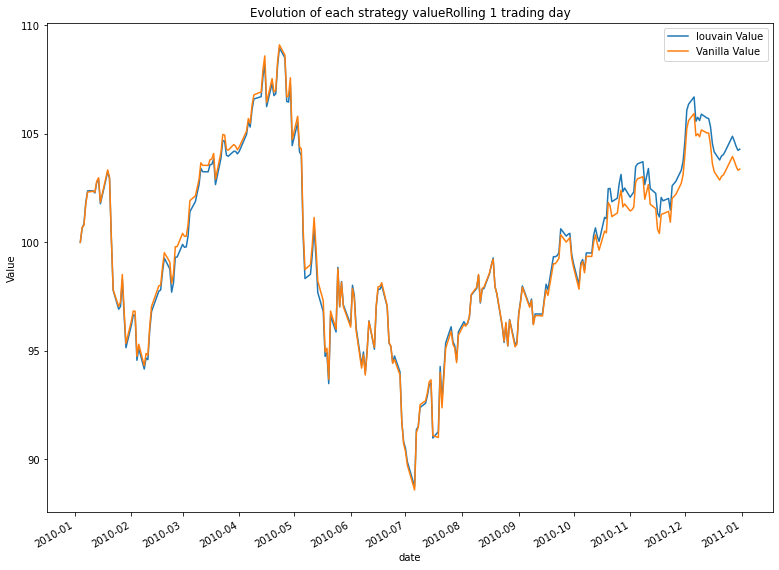

No handles with labels found to put in legend.


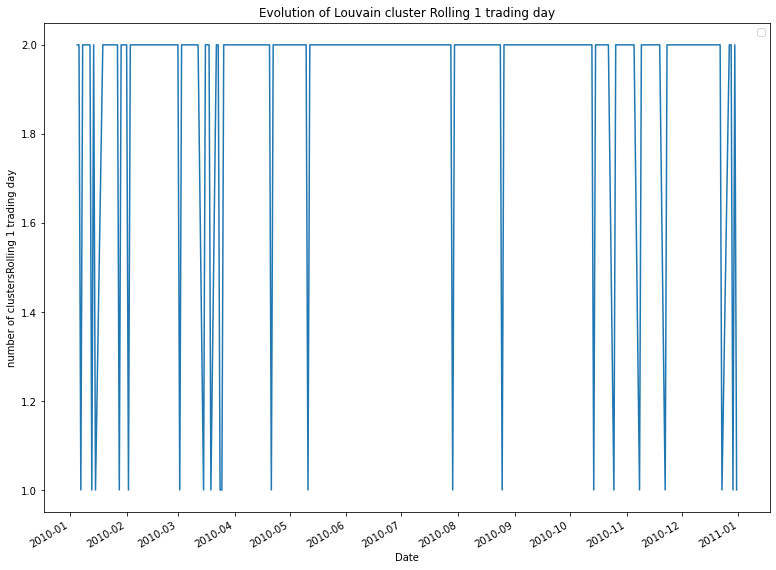

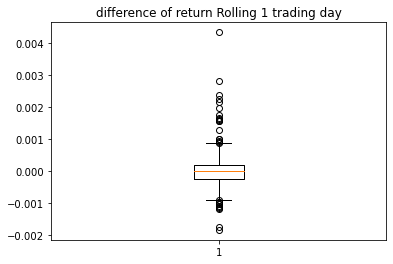

number of time where the number of louvain cluster is 1 : 21
rate of time where the number of louvain cluster is 1 : 0.08366533864541832


mean of louvain return :  0.00021814001266445599
mean of vanilla return :  0.00018276252657341055


std of louvain return :  0.01005135386663524
std of vanilla return :  0.010030587064699316


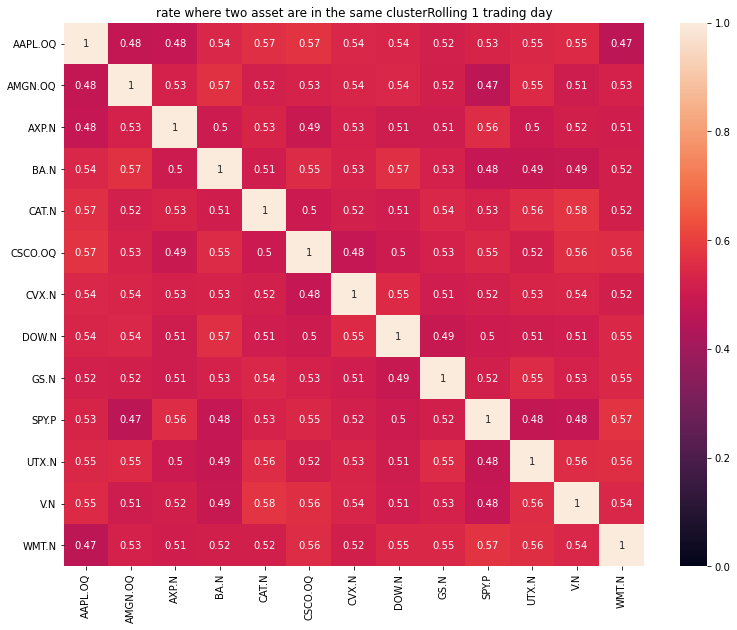

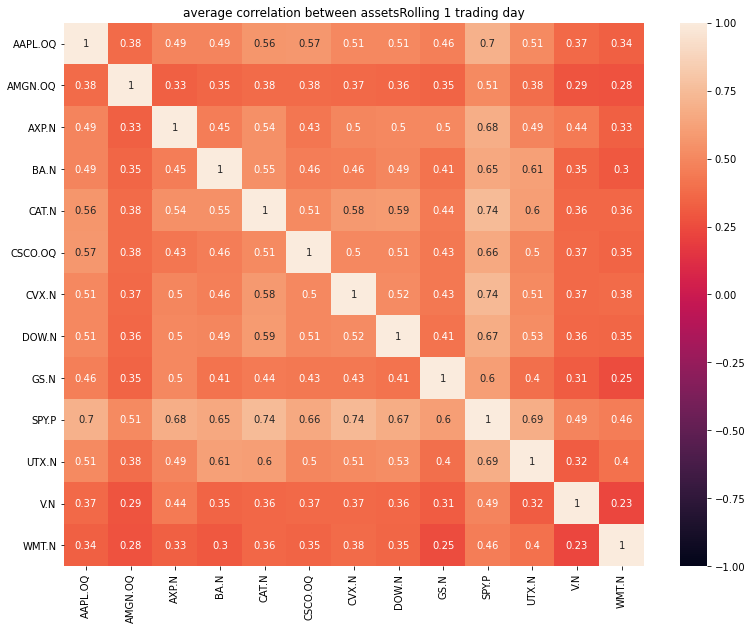

In [13]:
titre = 'Rolling 1 trading day'
get_graphs_perf(backtest_1J,titre)

the time to initialise the strategy is : 0 minutes 47.777193 seconds


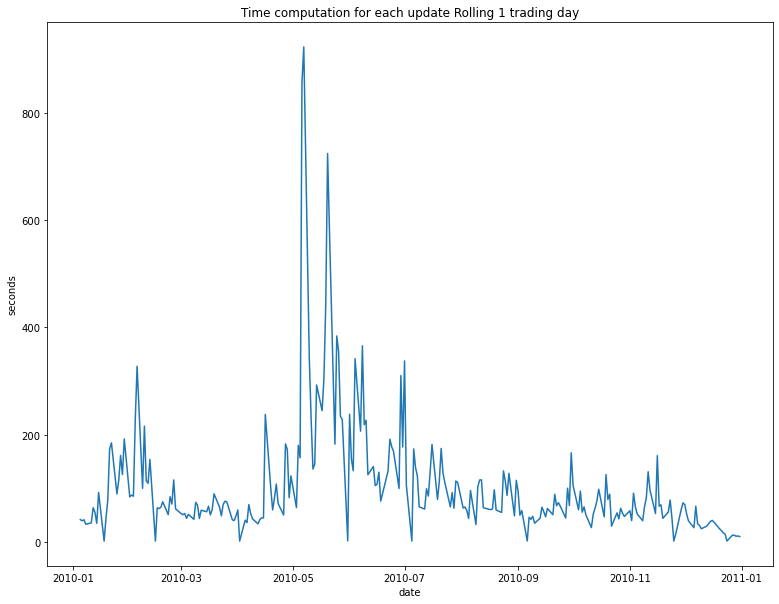

In [14]:
get_time_evo(1,Time,titre)

In [15]:
np.mean(Time[1:])

103.66659096309117

In [16]:
max(Time)

924.1204340457916

In [21]:
#We do our strategies for 20 rolling days
backtest_20J,Time = strategy_train_test(20)

avancement : 0.004184  pourcentage
avancement : 0.050209  pourcentage
avancement : 0.100418  pourcentage
avancement : 0.150628  pourcentage
avancement : 0.200837  pourcentage
avancement : 0.251046  pourcentage
avancement : 0.301255  pourcentage
avancement : 0.351464  pourcentage
avancement : 0.401674  pourcentage
avancement : 0.451883  pourcentage
avancement : 0.502092  pourcentage
avancement : 0.552301  pourcentage
avancement : 0.602510  pourcentage
avancement : 0.652720  pourcentage
avancement : 0.702929  pourcentage
avancement : 0.753138  pourcentage
avancement : 0.803347  pourcentage
avancement : 0.853556  pourcentage
avancement : 0.903766  pourcentage
avancement : 0.953975  pourcentage


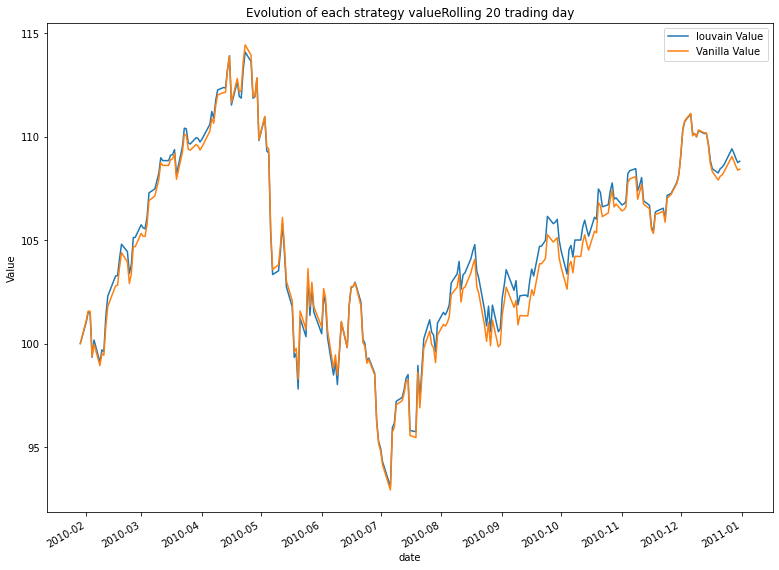

No handles with labels found to put in legend.


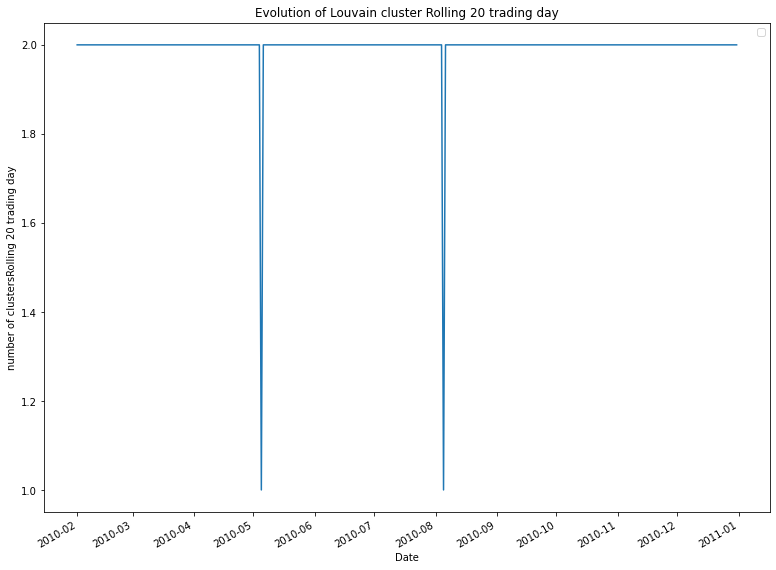

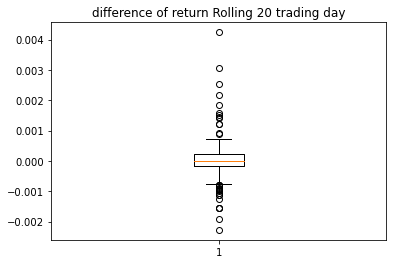

number of time where the number of louvain cluster is 1 : 2
rate of time where the number of louvain cluster is 1 : 0.008583690987124463


mean of louvain return :  0.0004125950911849334
mean of vanilla return :  0.0003961068922323998


std of louvain return :  0.00999354728858009
std of vanilla return :  0.009851480956280353


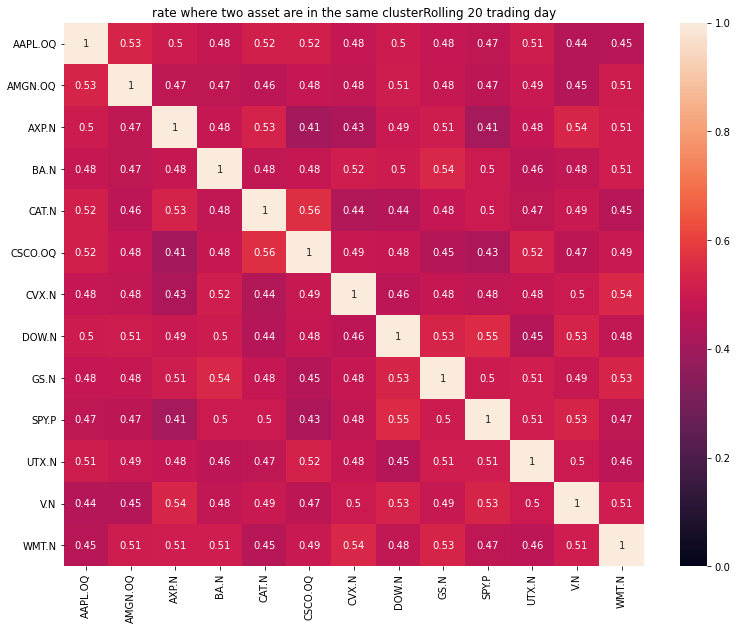

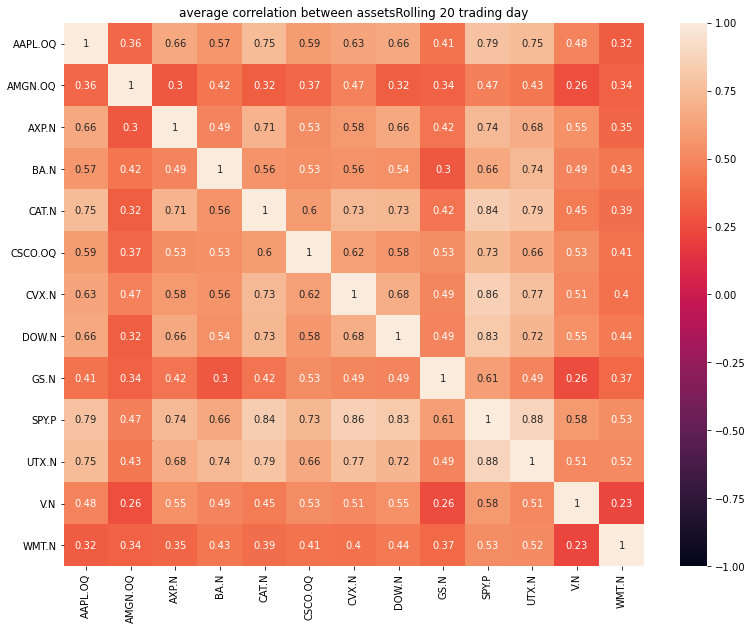

In [22]:
titre = 'Rolling 20 trading day'
get_graphs_perf(backtest_20J,titre)

the time to initialise the strategy is : 27 minutes 5.715280 seconds


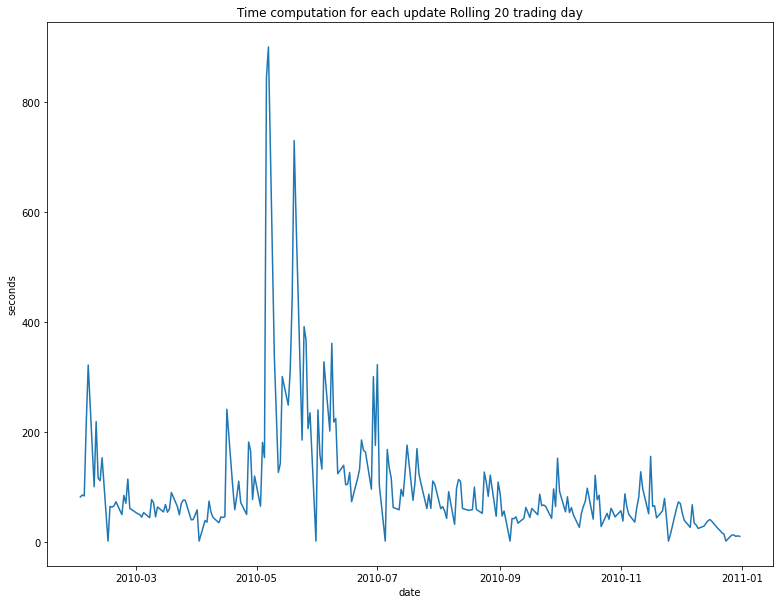

In [23]:
get_time_evo(20,Time,titre)

In [24]:
backtest_5J,Time = strategy_train_test(5)

avancement : 0.003937  pourcentage
avancement : 0.051181  pourcentage
avancement : 0.102362  pourcentage
avancement : 0.153543  pourcentage
avancement : 0.200787  pourcentage
avancement : 0.251969  pourcentage
avancement : 0.303150  pourcentage
avancement : 0.350394  pourcentage
avancement : 0.401575  pourcentage
avancement : 0.452756  pourcentage
avancement : 0.500000  pourcentage
avancement : 0.551181  pourcentage
avancement : 0.602362  pourcentage
avancement : 0.653543  pourcentage
avancement : 0.700787  pourcentage
avancement : 0.751969  pourcentage
avancement : 0.803150  pourcentage
avancement : 0.850394  pourcentage
avancement : 0.901575  pourcentage
avancement : 0.952756  pourcentage


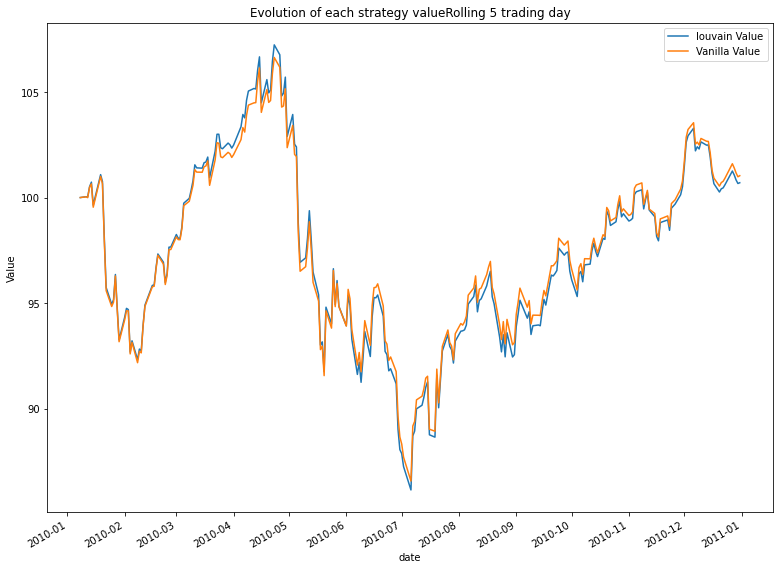

No handles with labels found to put in legend.


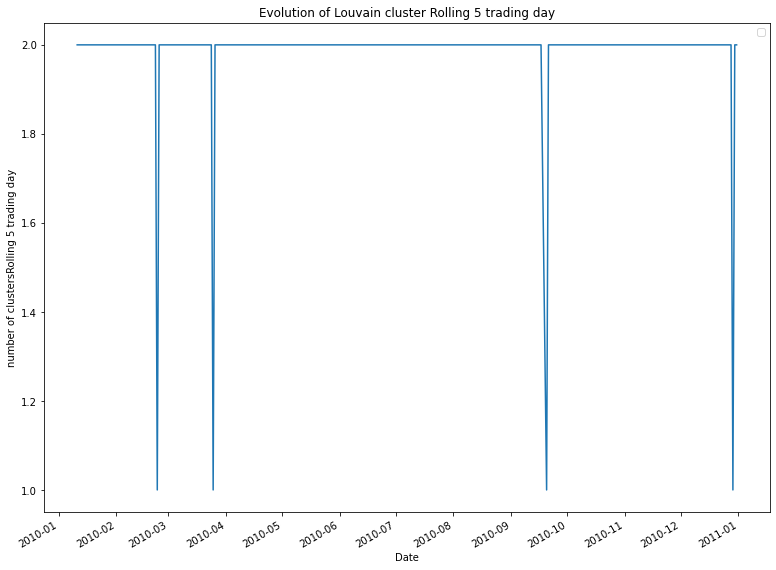

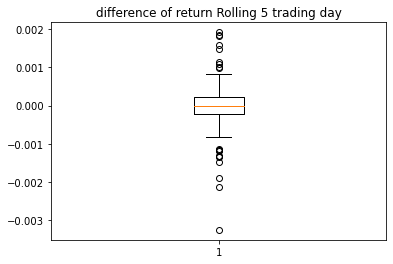

number of time where the number of louvain cluster is 1 : 4
rate of time where the number of louvain cluster is 1 : 0.016194331983805668


mean of louvain return :  7.897312402086989e-05
mean of vanilla return :  9.254659199089651e-05


std of louvain return :  0.010057075166830116
std of vanilla return :  0.010077969443210634


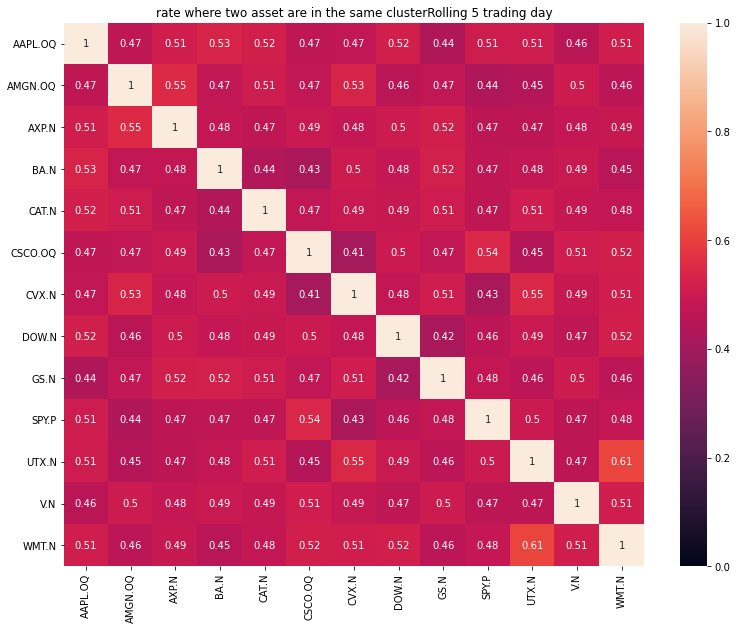

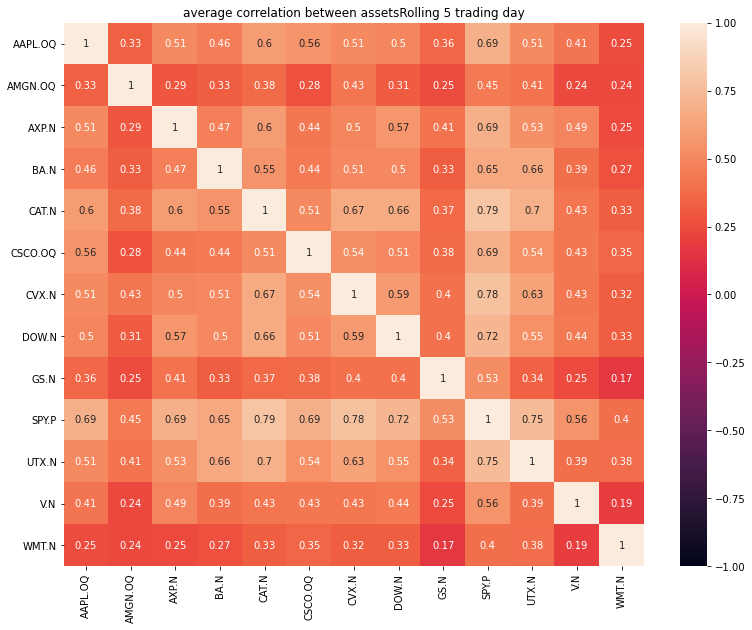

the time to initialise the strategy is : 3 minutes 13.874165 seconds


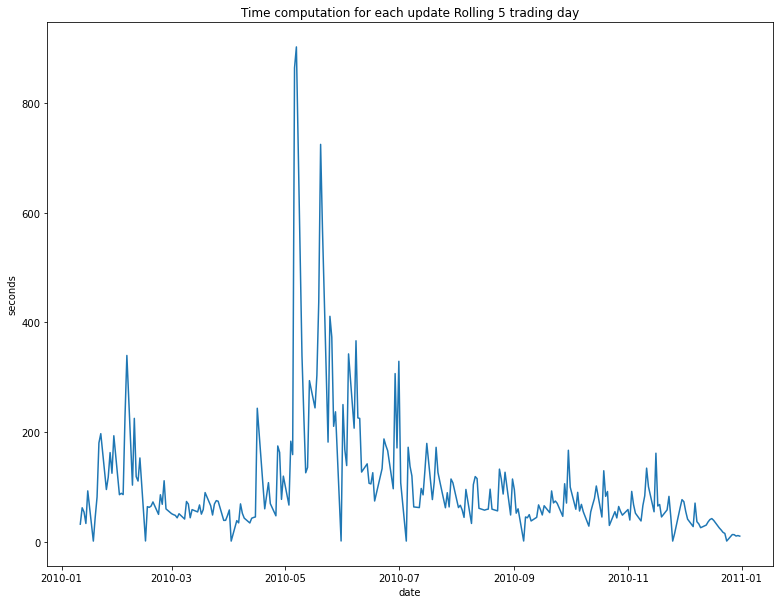

In [25]:
#We do our strategy for 5 rolling day
titre = 'Rolling 5 trading day'
get_graphs_perf(backtest_5J,titre)
get_time_evo(5,Time,titre)